Overview

3.1 Choosing a classification algorithm
First steps with scikit-learn
Training a perceptron via scikit-learn
Modeling class probabilities via logistic regression
Logistic regression intuition and conditional probabilities
Learning the weights of the logistic cost function
Training a logistic regression model with scikit-learn
Tackling overfitting via regularization
Maximum margin classification with support vector machines
Maximum margin intuition
Dealing with the nonlinearly separable case using slack variables
Alternative implementations in scikit-learn
Solving nonlinear problems using a kernel SVM
Using the kernel trick to find separating hyperplanes in higher dimensional space
Decision tree learning
Maximizing information gain – getting the most bang for the buck
Building a decision tree
Combining weak to strong learners via random forests
K-nearest neighbors – a lazy learning algorithm
Summary

In [6]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals
from IPython.display import HTML

# Common imports
import numpy as np
import os
import tensorflow as tf

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

import matplotlib.image as mpimg
def plot_external(img):
    img_name = os.path.join(".", "images",img)
    plots = mpimg.imread(img_name)
    plt.axis("off")
    plt.imshow(plots)    
    plt.show()
    
def plot_external2(imgpath):    
    plots = mpimg.imread(imgpath)
    plt.axis("off")
    plt.imshow(plots)    
    plt.show()
    
def mnist_load_data():
    (X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
    X_train = X_train.astype(np.float32).reshape(-1, 28*28) / 255.0
    X_test = X_test.astype(np.float32).reshape(-1, 28*28) / 255.0
    y_train = y_train.astype(np.int32)
    y_test = y_test.astype(np.int32)
    X_valid, X_train = X_train[:5000], X_train[5000:]
    y_valid, y_train = y_train[:5000], y_train[5000:]
    
    return (X_train, y_train), (X_valid, y_valid), (X_test, y_test)

# batch function
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

## 3.1 Choosing a classification algorithm

특정 문제에 알맞은 분류 알고리즘을 선택하려면 연습이 필요합니다. 알고리즘은 저마다 특징이 있고 일정한 가정을 전제로 합니다. 모든 경우에 뛰어난 성능을 낼 수 있는 분류 모델은 없습니다. 실제로 최소한 몇 개의 학습 알고리즘 성능을 비교하고 해당 문제에 최선인 모델을 선택하는 것이 항상 권장됩니다. 특성이나 샘플의 갯수에 따라 다르고 데이터셋에 있는 노이즈 데이터의 양과 클래스가 선형적으로 구분되는지 아닌지에 따라서도 다릅니다.  

결국 분류 모델의 예측 성능과 계산성능은 학습에 사용하려는 데이터에 크게 의존합니다. 머신 러닝 알고리즘을 훈련하기 위한 5가지 주요 단계는 다음과 같습니다.  

1. 특성을 선택하고 훈련샘플을 모음  
2. 성능 지표를 선택  
3. 분류 모델과 최적화 알고리즘을 선택  
4. 모델의 성능을 평가  
5. 알고리즘을 튜닝  

<br><br>

## 1.2 First steps with scikit-learn

In [ ]:
붓꽃 데이터셋은 간단하지만 알고리즘을 테스트하고 실험하고 이해할 때 자주 사용되기 때문에 사이킷럿에 이미 포함되어 있습니다. 

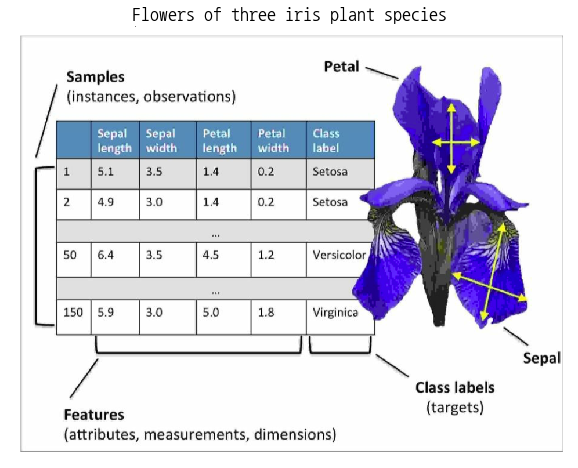

In [7]:
plt.figure(figsize=(12, 8))
plt.title("Flowers of three iris plant species", fontsize=18)
plot_external2("./images/classification/1.png")
plt.show()

시각화를 위해 붓꽃 데이터셋에서 2개의 특성만 사용하겠습니다.  
150개의 꽃 샘플에서 꽃잎 길이와 꽃잎 너비를 특성 행렬 $\mathbf{X}$에 할당하고 이에 상응하는 꽃 품종에 해당하는 클래스 레이블을 벡터 $\mathbf{y}$에 할당합니다.

In [9]:
from sklearn.datasets import load_iris
import numpy as np

iris = load_iris()
X = iris.data[:, [2, 3]]
y = iris.target

print('Class labels:', np.unique(y))

Class labels: [0 1 2]


`np.unique()`함수는 iris.target에 저장된 3개의 고유한 클래스 레이블을 반환합니다. 결과에서 보듯이 붓꽃의 클래스 이름인 Iris-setosa, Iris-versicolor, Iris-virginica는 이미 정수로 저장되어 있습니다(0, 1, 2). 

70%는 훈련 데이터 30%는 테스트 데이터로 분할합니다.

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1, stratify=y)

In [11]:
print('Labels counts in y:', np.bincount(y))
print('Labels counts in y_train:', np.bincount(y_train))
print('Labels counts in y_test:', np.bincount(y_test))

Labels counts in y: [50 50 50]
Labels counts in y_train: [35 35 35]
Labels counts in y_test: [15 15 15]


특성을 표준화합니다(평균이 0, 분산이 1).

In [12]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

<br><br>

### 1.2.1 Training a perceptron via scikit-learn

Redefining the `plot_decision_region` function from chapter 2:

In [15]:
from sklearn.linear_model import Perceptron

ppn = Perceptron(max_iter=40, eta0=0.1, random_state=1)
ppn.fit(X_train_std, y_train)

Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=0.1,
           fit_intercept=True, max_iter=40, n_iter_no_change=5, n_jobs=None,
           penalty=None, random_state=1, shuffle=True, tol=0.001,
           validation_fraction=0.1, verbose=0, warm_start=False)

In [16]:
y_pred = ppn.predict(X_test_std)
print('Misclassified samples: %d' % (y_test != y_pred).sum())

Misclassified samples: 1


In [17]:
from sklearn.metrics import accuracy_score

print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))

Accuracy: 0.98


In [18]:
print('Accuracy: %.2f' % ppn.score(X_test_std, y_test))

Accuracy: 0.98


In [19]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt


def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')

    # highlight test samples
    if test_idx:
        # plot all samples
        X_test, y_test = X[test_idx, :], y[test_idx]

        plt.scatter(X_test[:, 0],
                    X_test[:, 1],
                    c='',
                    edgecolor='black',
                    alpha=1.0,
                    linewidth=1,
                    marker='o',
                    s=100, 
                    label='test set')

표준화된 훈련 데이터를 사용하여 퍼셉트론 모델을 훈련합니다:

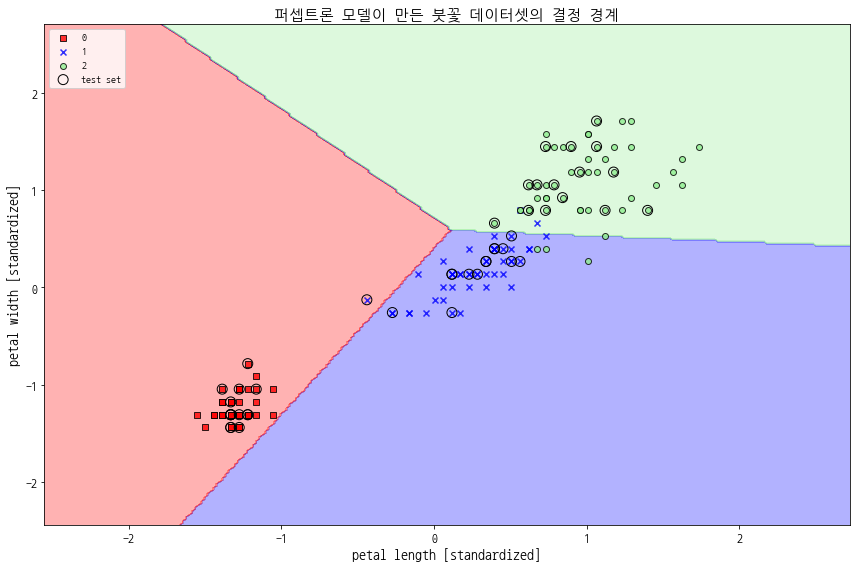

In [26]:
X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))

plt.figure(figsize=(12, 8))
plot_decision_regions(X=X_combined_std, y=y_combined,
                      classifier=ppn, test_idx=range(105, 150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.title("퍼셉트론 모델이 만든 붓꽃 데이터셋의 결정 경계")
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()